## Part 2: NN Model
- Строим нейросетевую модель обучающуюся на полученных признаках, без описаний.
- Настраиваем параметры модели.
- Делаем блендинг результатов с ML моделью.

## Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# For NLP
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import re

# For ML
# from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif


# Keras
import tensorflow as tf

# GPU memory
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations


# Charts
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

## Functions

In [2]:
# Метрика
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Data

In [4]:
data = pd.read_csv('data.csv')
sample_submission = pd.read_csv(r'data/sample_submission.csv')

In [5]:
data

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,sample,price,model,xDrive,sDrive,CDI,AMG,BlueTEC,Long,длинный,4MATIC,BlueEfficiency,TRONIC,компактный,HYBRID,mileage_prod_date,mileage_owns,owns_year
0,универсал 5 дв.,MERCEDES,чёрный,300 задний w124 бензин черный mercedes универс...,3.0,220,бензин,350000,1984,W124,5,1991,автоматическая,3,Оригинал,задний,0,0.0,300,0,0,0,0,0,0,0,0,0,0,0,0,11666,116666,10
1,купе,BMW,белый,640d полный 6er дизель белый bmw купе любимый...,3.0,313,дизель,15000,2011,6ER,2,2013,автоматическая,1,Оригинал,полный,0,0.0,640d,1,0,0,0,0,0,0,0,0,0,0,0,1875,15000,8
2,купе,BMW,пурпурный,325xi полный 3er бензин пурпурный bmw купе пе...,2.5,218,бензин,166600,2005,3ER,2,2008,автоматическая,3,Оригинал,полный,0,0.0,325xi,0,0,0,0,0,0,0,0,0,0,0,0,12815,55533,4
3,седан,BMW,белый,318i задний 3er бензин белый bmw седан отличн...,2.0,136,бензин,147000,2005,3ER,4,2007,автоматическая,2,Оригинал,задний,0,0.0,318i,0,0,0,0,0,0,0,0,0,0,0,0,10500,73500,7
4,седан,BMW,чёрный,520d полный 5er дизель черный bmw седан немка...,2.0,190,дизель,24000,2016,5ER,4,2019,автоматическая,1,Оригинал,полный,0,0.0,520d,1,0,0,0,0,0,0,0,0,0,0,0,12000,24000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,седан,BMW,серый,320i задний 3er бензин серый bmw седан любимы...,2.0,150,бензин,232777,2005,3ER,4,2006,автоматическая,3,Оригинал,задний,1,550000.0,320i,0,0,0,0,0,0,0,0,0,0,0,0,15518,77592,5
8346,седан,BMW,чёрный,520d задний 5er дизель черный bmw седан офици...,2.0,190,дизель,33700,2013,5ER,4,2016,автоматическая,3,Оригинал,задний,1,1900000.0,520d,0,0,0,0,0,0,0,0,0,0,0,0,6740,11233,1
8347,седан,BMW,белый,318i задний 3er бензин белый bmw седан торг м...,2.0,143,бензин,200000,2008,3ER,4,2008,автоматическая,3,Оригинал,задний,1,530000.0,318i,0,0,0,0,0,0,0,0,0,0,0,0,15384,66666,4
8348,седан,AUDI,чёрный,long полный a8 бензин черный audi седан отлич...,3.0,310,бензин,72000,2013,A8,4,2016,автоматическая,3,Оригинал,полный,1,1970000.0,Long,0,0,0,0,0,1,0,0,0,0,0,0,14400,24000,1


## PreProc Tabular Data

In [6]:
# Категориальные признаки
categorical_features = [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'model_info',
    'numberOfDoors',
    'vehicleTransmission',
    'Владельцы',
    'ПТС',
    'Привод',
    'model'
]

# Числовые признаки
numerical_features = [
    'engineDisplacement',
    'mileage',
    'modelDate',
    'mileage_prod_date',
    'mileage_owns',
    'owns_year',
    'productionDate',
    'enginePower'
]

In [7]:
def preproc_data(df_input):

    df_output = df_input.copy()

    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id'], axis=1, inplace=True)

    # Логарифмирование
    for col in numerical_features:
        df_output[col] = np.log(df_output[col] + 1)
    # df_output['price'] = np.log(df_output['price'] + 1)

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)

    return df_output

In [8]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,xDrive,sDrive,CDI,AMG,BlueTEC,Long,длинный,4MATIC,BlueEfficiency,TRONIC,компактный,HYBRID,mileage_prod_date,mileage_owns,owns_year,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_18,model_19,model_20,model_21,model_22,model_23,model_24,model_25,model_26,model_27,model_28,model_29,model_30,model_31,model_32,model_33,model_34,model_35,model_36,model_37,model_38,model_39,model_40,model_41,model_42,model_43,model_44,model_45,model_46,model_47,model_48,model_49,model_50,model_51,model_52,model_53,model_54,model_55,model_56,model_57,model_58,model_59,model_60,model_61,model_62,model_63,model_64,model_65,model_66,model_67,model_68,model_69,model_70,model_71,model_72,model_73,model_74,model_75,model_76,model_77,model_78,model_79,model_80,model_81,model_82,model_83,model_84,model_85,model_86,model_87,model_88,model_89,model_90,model_91,model_92,model_93,model_94,model_95,model_96,model_97,model_98,model_99,model_100,model_101,model_102,model_103,model_104,model_105,model_106,model_107,model_108,model_109,model_110,model_111,model_112,model_113,model_114,model_115,model_116,model_117,model_118,model_119,model_120,model_121,model_122,model_123,model_124,model_125,model_126,model_127,model_128,model_129,model_130,model_131,model_132,model_133,model_134,model_135,model_136,model_137,model_138,model_139,model_140,model_141,model_142,model_143,model_144,model_145,model_146,model_147,model_148,model_149,model_150,model_151,model_152,model_153,model_154,model_15

### Split data

In [9]:
# Выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Model 3: Tabular NN

In [11]:
K.clear_session()

model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.25))
model.add(L.Dense(1, activation="linear"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               222208    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 353,793
Trainable params: 353,793
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [14]:
checkpoint = ModelCheckpoint(
    'working/best_model_tabular_nn.hdf5', monitor=['val_MAPE'], verbose=1, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

### Fit

In [15]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                    )

122/500
12/12 [==============================] - 0s 9ms/step - loss: 14.3864 - MAPE: 14.3864 - val_loss: 13.9649 - val_MAPE: 13.9649

Epoch 00122: saving model to working\best_model_tabular_nn.hdf5
Epoch 123/500
12/12 [==============================] - 0s 9ms/step - loss: 14.2261 - MAPE: 14.2261 - val_loss: 14.0041 - val_MAPE: 14.0041

Epoch 00123: saving model to working\best_model_tabular_nn.hdf5
Epoch 124/500
12/12 [==============================] - 0s 9ms/step - loss: 14.1629 - MAPE: 14.1629 - val_loss: 13.9706 - val_MAPE: 13.9706

Epoch 00124: saving model to working\best_model_tabular_nn.hdf5
Epoch 125/500
12/12 [==============================] - 0s 9ms/step - loss: 14.0959 - MAPE: 14.0959 - val_loss: 13.9549 - val_MAPE: 13.9549

Epoch 00125: saving model to working\best_model_tabular_nn.hdf5
Epoch 126/500
12/12 [==============================] - 0s 10ms/step - loss: 14.2806 - MAPE: 14.2806 - val_loss: 13.9475 - val_MAPE: 13.9475

Epoch 00126: saving model to working\best_model_t

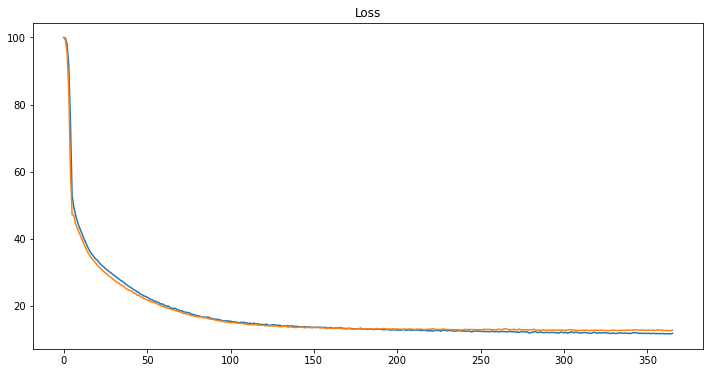

In [16]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [17]:
model.load_weights('working/best_model_tabular_nn.hdf5')
model.save('working/nn_1.hdf5')

In [18]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.72%


In [19]:
sub_predict_nn1 = model.predict(X_sub)

sample_submission['price'] = sub_predict_nn1[:, 0]
sample_submission.to_csv(r'csv/without_round_nn1.csv', index=False)

# округлим
sample_submission['price'] = (sample_submission['price'] // 1000) * 1000

sample_submission.to_csv(r'csv/nn1_submission.csv', index=False)

## Выводы по части 2:
- Создана нейронная сеть для работы с табличными признаками.
- Настроены параметры сети (протестированы различные комбинации слоев, количества нейронов в слоях, варианты batch и dropout нормализации).
- Лучшая метрика на тестах: 12.72%.
- Применен Блендинг NN и Catboost - метрика: 11.52%.